
# Predictive Model for School Dropout

This notebook presents the development of a predictive model for school dropout.


To start, we need all to import all libraries needed and get the dataset from google drive.

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
!pwd # Print working directory

%cd "/content/gdrive/MyDrive/ModeloPredictivoDropout"
!ls # List files located in defined folder

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/ModeloPredictivoDropout
/content/gdrive/MyDrive/ModeloPredictivoDropout
dropout.csv  dropout.gsheet  ModeloPredictivoDropout.ipynb


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from funpymodeling.exploratory import corr_pair
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [ ]:
!pip install funpymodeling
from funpymodeling.exploratory import corr_pair


## Data Preprocessing

The first step in training a model is to obtain useful data. While the dataset used here comes from a trusted source, that alone isn't enough to consider it useful data yet, at least not for training a predictive model.

With this in mind, we began analyzing the provided dataset. The first noticeable issue is the presence of many null values within certain variables. Upon closer inspection, we observed that many values are filled as "No information" or "Does not apply," which could be considered null values from an analytical perspective.

In [ ]:
dataSet = pd.read_csv('dropout.csv')
dataSetO = dataSet
dataSet.head()
len(dataSet['student.id'])

143326

In [ ]:
dataSet.isnull().sum()

student.id                          0
generation                          0
educational.model                   0
level                               0
gender                              0
age                                 0
max.degree.parents                  0
father.education.complete           0
father.education.summary            0
mother.education.complete           0
mother.education.summary            0
parents.exatec                      0
father.exatec                       0
mother.exatec                       0
tec.no.tec                          0
foreign                             0
zone.type                           0
first.generation                    0
school                              0
program                             0
region                              0
PNA                                 0
admission.test                   2177
online.test                         0
english.evaluation                  0
admission.rubric                33489
general.math

In [ ]:
(dataSet == "No information").sum()

student.id                           0
generation                           0
educational.model                    0
level                                0
gender                               0
age                                  0
max.degree.parents               46100
father.education.complete        49351
father.education.summary         49351
mother.education.complete        50458
mother.education.summary         50458
parents.exatec                   24904
father.exatec                    26612
mother.exatec                    25988
tec.no.tec                           0
foreign                              0
zone.type                       101920
first.generation                 37372
school                               0
program                              0
region                               0
PNA                                  0
admission.test                       0
online.test                          0
english.evaluation                   0
admission.rubric         

In [ ]:
(dataSet == "Does not apply").sum()

student.id                          0
generation                          0
educational.model                   0
level                               0
gender                              0
age                                 0
max.degree.parents                  0
father.education.complete           0
father.education.summary            0
mother.education.complete           0
mother.education.summary            0
parents.exatec                      0
father.exatec                       0
mother.exatec                       0
tec.no.tec                          0
foreign                             0
zone.type                           0
first.generation                65809
school                              0
program                             0
region                              0
PNA                                 0
admission.test                      0
online.test                         0
english.evaluation                  0
admission.rubric                    0
general.math

It was observed that if all rows containing either null values or values representing null were removed, we would end up with zero rows of data. Therefore, it was decided to split the dataset into three subdatasets. Each subdataset eliminated certain variables and the rows with null values in the remaining variables.

Once separated, all variable values were converted to numeric values or replaced with binary dummy variables (0,1). This allowed for the analysis of mathematical values such as mean and standard deviation. More importantly, with all data being numeric, we could obtain the correlation between variables using the Pearson correlation method.

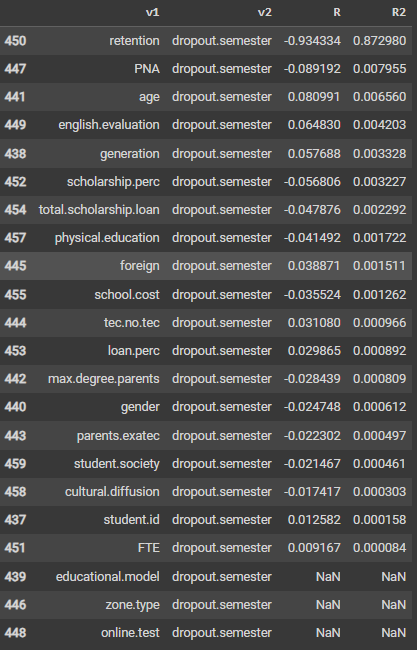

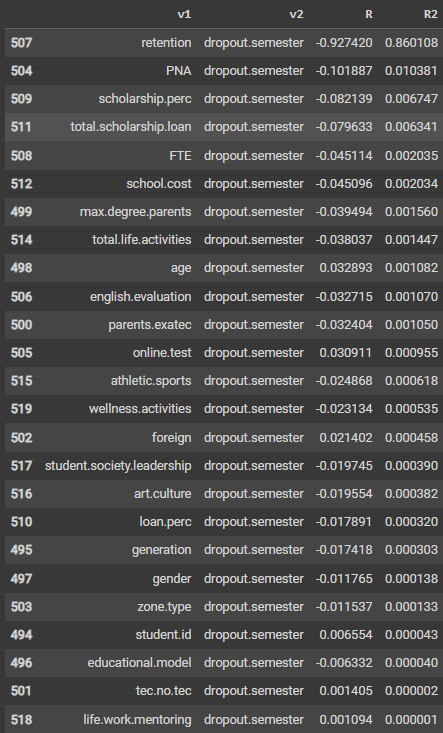

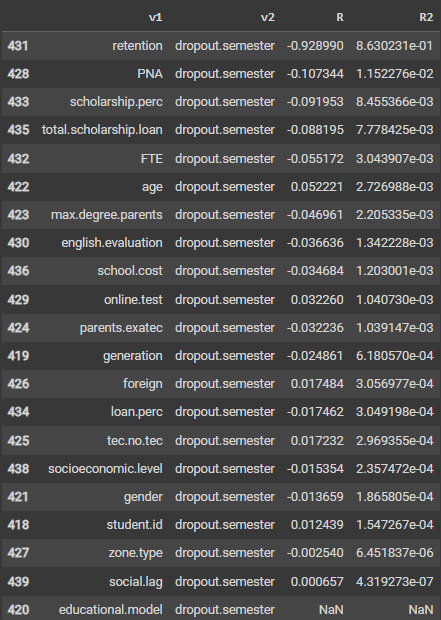

###Variable selection

The variable which we will be using as y is the number of the semester in which they abandon their studies, considering that, we decided to get the correlation from the varialbes with the number of semester only.
What we discovered right after is that all the variables with the highest correlation coefficient were the ones that appear in all subdatasets. With that information, we decided to select those variables for the training of the model with the original datasets, although we eliminated almost a third of the null values, the dataset is large enough to have about 100,000 data rows after that.

In [ ]:
commonColumnsCor = ['PNA','scholarship.perc', 'FTE','age','school.cost','generation','max.degree.parents','english.evaluation','foreign','dropout.semester']
dataSetO = dataSetO[commonColumnsCor]
(dataSetO == "No information").sum()

PNA                       0
scholarship.perc          0
FTE                       0
age                       0
school.cost               0
generation                0
max.degree.parents    46100
english.evaluation        0
foreign                   0
dropout.semester          0
dtype: int64

In [ ]:
dataSetO = dataSetO[dataSetO['max.degree.parents'] != "No information"]
(dataSetO == "No information").sum()

PNA                   0
scholarship.perc      0
FTE                   0
age                   0
school.cost           0
generation            0
max.degree.parents    0
english.evaluation    0
foreign               0
dropout.semester      0
dtype: int64

In [ ]:
(dataSetO == "Does not apply").sum()

PNA                   0
scholarship.perc      0
FTE                   0
age                   0
school.cost           0
generation            0
max.degree.parents    0
english.evaluation    0
foreign               0
dropout.semester      0
dtype: int64

In [ ]:
len(dataSetO['age'])

97226

In [ ]:
dataSetO.head()

AttributeError: 'Index' object has no attribute '_format_flat'

       PNA  scholarship.perc   FTE  age school.cost generation  \
2    83.76              0.35  1.08   23   High cost       AD18   
64   83.09              0.00  1.08   18   High cost       AD15   
123  79.00              0.00  1.08   18   High cost       AD16   
128  87.23              0.30  1.08   18   High cost       AD16   
134  90.88              0.50  1.08   18   High cost       AD16   

       max.degree.parents  english.evaluation        foreign  dropout.semester  
2    Undergraduate degree                   6  Yes: National                 4  
64   Undergraduate degree                   6          Local                 0  
123  Undergraduate degree                   6          Local                 0  
128  Undergraduate degree                   6          Local                 0  
134         Master degree                   6  Yes: National                 0  

Once again we replace many data values with numeric ones with the objective of using them to train the model

In [ ]:
dataSetO['generation'] = dataSetO['generation'].replace({'AD14':1, 'AD15':2, 'AD16':3, 'AD17':4, 'AD18':5, 'AD19':6, 'AD20':7})
dataSetO['max.degree.parents'] = dataSetO['max.degree.parents'].replace({'No degree':1, 'Undergraduate degree':2, 'Master degree': 3, 'PhD': 4})
dataSetO['school.cost'] = dataSetO['school.cost'].replace({'Not defined':0, 'Public':1, 'Low cost':2, 'Medium cost':3, 'Medium high cost':4, 'High cost':5})

For the case of the foreign variable we decided that creating dummy variables was better since it doesn't follow a specific numeric order unlike the other ones.

In [ ]:
dataSetO = pd.get_dummies(dataSetO,columns=['foreign'])
dataSetO.head()

AttributeError: 'Index' object has no attribute '_format_flat'

       PNA  scholarship.perc   FTE  age  school.cost  generation  \
2    83.76              0.35  1.08   23            5           5   
64   83.09              0.00  1.08   18            5           2   
123  79.00              0.00  1.08   18            5           3   
128  87.23              0.30  1.08   18            5           3   
134  90.88              0.50  1.08   18            5           3   

     max.degree.parents  english.evaluation  dropout.semester  foreign_Local  \
2                     2                   6                 4          False   
64                    2                   6                 0           True   
123                   2                   6                 0           True   
128                   2                   6                 0           True   
134                   3                   6                 0          False   

     foreign_Yes: Foreigner  foreign_Yes: National  
2                     False                   True  
64  

In [ ]:
dataSetO['foreign_Local'] = dataSetO['foreign_Local'].replace({False:0, True:1})
dataSetO['foreign_Yes: Foreigner'] = dataSetO['foreign_Yes: Foreigner'].replace({False:0, True:1})
dataSetO['foreign_Yes: National'] = dataSetO['foreign_Yes: National'].replace({False:0, True:1})

In [ ]:
dataSetO.head()

AttributeError: 'Index' object has no attribute '_format_flat'

       PNA  scholarship.perc   FTE  age  school.cost  generation  \
2    83.76              0.35  1.08   23            5           5   
64   83.09              0.00  1.08   18            5           2   
123  79.00              0.00  1.08   18            5           3   
128  87.23              0.30  1.08   18            5           3   
134  90.88              0.50  1.08   18            5           3   

     max.degree.parents  english.evaluation  dropout.semester  foreign_Local  \
2                     2                   6                 4              0   
64                    2                   6                 0              1   
123                   2                   6                 0              1   
128                   2                   6                 0              1   
134                   3                   6                 0              0   

     foreign_Yes: Foreigner  foreign_Yes: National  
2                         0                      1  
64  

In [ ]:
dataSetO.describe()

AttributeError: 'Index' object has no attribute '_format_flat'

                PNA  scholarship.perc           FTE           age  \
count  97226.000000      97226.000000  97226.000000  97226.000000   
mean      88.544356          0.179384      1.009513     16.382799   
std        6.015754          0.233060      0.085370      1.787943   
min        0.000000          0.000000      0.040000     13.000000   
25%       84.000000          0.000000      1.000000     15.000000   
50%       89.000000          0.000000      1.000000     16.000000   
75%       93.000000          0.400000      1.000000     18.000000   
max      100.000000          1.000000      1.420000     55.000000   

        school.cost    generation  max.degree.parents  english.evaluation  \
count  97226.000000  97226.000000        97226.000000        97226.000000   
mean       3.611873      4.990301            2.275317            3.288472   
std        1.540651      1.694581            0.726095            2.915331   
min        0.000000      1.000000            1.000000            0.000

Here we can observe the correlation of the dataset that will be used to train/test the models, unfortunately as can be observed on the following correlation matrix, not even 1 of the variables gets to have a 0.1 correlation coefficient individually. At the same time, we have to take into consideration that they ar the best ones, because of that the selection of variables won't change unless bad results come out of the models.

In [ ]:
pairCorrO = corr_pair(dataSetO)
pairCorrTargetO = pairCorrO[pairCorrO['v2']=='dropout.semester'].sort_values('R2', ascending = False)
pairCorrTargetO

AttributeError: 'Index' object has no attribute '_format_flat'

                         v1                v2         R        R2
96                      PNA  dropout.semester -0.095070  0.009038
97         scholarship.perc  dropout.semester -0.073585  0.005415
99                      age  dropout.semester  0.058480  0.003420
100             school.cost  dropout.semester -0.045331  0.002055
101              generation  dropout.semester  0.036951  0.001365
102      max.degree.parents  dropout.semester -0.035773  0.001280
98                      FTE  dropout.semester -0.030923  0.000956
106  foreign_Yes: Foreigner  dropout.semester  0.027913  0.000779
105           foreign_Local  dropout.semester -0.026039  0.000678
103      english.evaluation  dropout.semester  0.015732  0.000247
107   foreign_Yes: National  dropout.semester  0.015511  0.000241

At this point the dataset is divided into x and y which are also divided into train and test data to be used for what their name suggests

In [ ]:
newColumnsO = ['PNA','scholarship.perc', 'FTE','age','school.cost','generation','max.degree.parents','english.evaluation','foreign_Local','foreign_Yes: Foreigner','foreign_Yes: National']
x_trainO, x_testO, y_trainO, y_testO = train_test_split(dataSetO[newColumnsO], dataSetO['dropout.semester'],train_size=0.7)

#Utilized models

The first model that we experiment with is the XGBoost, this algorithm is robust and tends to be very precise, although it generally consumes a lot of computational processing, for a dataset of almost 100,000 rows it isn't a bad option to choose.

Considering that this model's hiperparameters can change the results a lot, changing a few of them from the standard on differents instances is a good way to observe how much it can change for this specific case scenario

In [ ]:
gbc_model1 = GradientBoostingClassifier(loss='deviance')
gbc_model2 = GradientBoostingClassifier(learning_rate=0.2)
gbc_model3 = GradientBoostingClassifier(max_depth = 5)
gbc_model4 = GradientBoostingClassifier(loss='log_loss')

gbc_model1.fit(x_trainO, y_trainO)
gbc_model2.fit(x_trainO, y_trainO)
gbc_model3.fit(x_trainO, y_trainO)
gbc_model4.fit(x_trainO, y_trainO)

y_predO1 = gbc_model1.predict(x_testO)
y_predO2 = gbc_model2.predict(x_testO)
y_predO3 = gbc_model3.predict(x_testO)
y_predO4 = gbc_model4.predict(x_testO)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


The model ends up resulting in predictions with 93% accuracy in predicing both train data and test data, confirming it isn't overfitted.

In [ ]:
y_predOtraind1 = gbc_model1.predict(x_trainO)
gbcrt1 = accuracy_score(y_trainO, y_predOtraind1)
y_predOtraind2 = gbc_model2.predict(x_trainO)
gbcrt2 = accuracy_score(y_trainO, y_predOtraind2)
y_predOtraind3 = gbc_model3.predict(x_trainO)
gbcrt3 = accuracy_score(y_trainO, y_predOtraind3)
y_predOtraind4 = gbc_model4.predict(x_trainO)
gbcrt4 = accuracy_score(y_trainO, y_predOtraind4)

print(gbcrt1)
print(gbcrt2)
print(gbcrt3)
print(gbcrt4)

0.9327044579623263
0.9337917658467777
0.9363043286608481
0.9327044579623263


In [ ]:
gbcac1 = accuracy_score(y_testO, y_predO1)
gbcac2 = accuracy_score(y_testO, y_predO2)
gbcac3 = accuracy_score(y_testO, y_predO3)
gbcac4 = accuracy_score(y_testO, y_predO4)
print(gbcac1)
print(gbcac2)
print(gbcac3)
print(gbcac4)

0.9320145364783324
0.9307117388919364
0.9304031815688426
0.9319459681843115


In [ ]:
gbcpr1 = precision_score(y_testO, y_predO1, average='weighted')
gbcpr2 = precision_score(y_testO, y_predO2, average='weighted')
gbcpr3 = precision_score(y_testO, y_predO3, average='weighted')
gbcpr4 = precision_score(y_testO, y_predO4, average='weighted')
print(gbcpr1)
print(gbcpr2)
print(gbcpr3)
print(gbcpr4)

0.882351758059429
0.8736036037571899
0.8761406287067498
0.880950095401419


In [ ]:
gbcr1 = recall_score(y_testO, y_predO1, average='weighted')
gbcr2 = recall_score(y_testO, y_predO2, average='weighted')
gbcr3 = recall_score(y_testO, y_predO3, average='weighted')
gbcr4 = recall_score(y_testO, y_predO4, average='weighted')
print(gbcr1)
print(gbcr2)
print(gbcr3)
print(gbcr4)

0.9320145364783324
0.9307117388919364
0.9304031815688426
0.9319459681843115


In [ ]:
gbcf1 = f1_score(y_testO, y_predO1, average='weighted')
gbcf2 = f1_score(y_testO, y_predO2, average='weighted')
gbcf3 = f1_score(y_testO, y_predO3, average='weighted')
gbcf4 = f1_score(y_testO, y_predO4, average='weighted')
print(gbcf1)
print(gbcf2)
print(gbcf3)
print(gbcf4)

0.9001896803854098
0.8996686002902647
0.8996862577313897
0.9001552222420769


For the next model we tried a logistic regression, after adjusting it with the training data and predicting, we ended with similar results, all of them getting to the 93% accuracy.

In [ ]:
lr_model1 = LogisticRegression()
lr_model2 = LogisticRegression(penalty=None)
lr_model3 = LogisticRegression(solver='saga')
lr_model4 = LogisticRegression(fit_intercept=False)

lr_model1.fit(x_trainO, y_trainO)
lr_model2.fit(x_trainO, y_trainO)
lr_model3.fit(x_trainO, y_trainO)
lr_model4.fit(x_trainO, y_trainO)

y_predO1 = lr_model1.predict(x_testO)
y_predO2 = lr_model2.predict(x_testO)
y_predO3 = lr_model3.predict(x_testO)
y_predO4 = lr_model4.predict(x_testO)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [ ]:
y_predOtraind1 = lr_model1.predict(x_trainO)
lrrt1 = accuracy_score(y_trainO, y_predOtraind1)
y_predOtraind2 = lr_model2.predict(x_trainO)
lrrt2 = accuracy_score(y_trainO, y_predOtraind2)
y_predOtraind3 = lr_model3.predict(x_trainO)
lrrt3 = accuracy_score(y_trainO, y_predOtraind3)
y_predOtraind4 = lr_model4.predict(x_trainO)
lrrt4 = accuracy_score(y_trainO, y_predOtraind4)

print(lrrt1)
print(lrrt2)
print(lrrt3)
print(lrrt4)

0.9315583766787152
0.9315583766787152
0.9315436833289253
0.9315583766787152


In [ ]:
lrac1 = accuracy_score(y_testO, y_predO1)
lrac2 = accuracy_score(y_testO, y_predO2)
lrac3 = accuracy_score(y_testO, y_predO3)
lrac4 = accuracy_score(y_testO, y_predO4)
print(lrac1)
print(lrac2)
print(lrac3)
print(lrac4)

0.9325287986834887
0.9325287986834887
0.9325287986834887
0.9325287986834887


In [ ]:
lrpr1 = accuracy_score(y_testO, y_predO1)
lrpr2 = accuracy_score(y_testO, y_predO2)
lrpr3 = accuracy_score(y_testO, y_predO3)
lrpr4 = accuracy_score(y_testO, y_predO4)
print(lrpr1)
print(lrpr2)
print(lrpr3)
print(lrpr4)

0.9325287986834887
0.9325287986834887
0.9325287986834887
0.9325287986834887


In [ ]:
lrr1 = recall_score(y_testO, y_predO1, average='weighted')
lrr2 = recall_score(y_testO, y_predO2, average='weighted')
lrr3 = recall_score(y_testO, y_predO3, average='weighted')
lrr4 = recall_score(y_testO, y_predO4, average='weighted')
print(lrr1)
print(lrr2)
print(lrr3)
print(lrr4)

0.9325287986834887
0.9325287986834887
0.9325287986834887
0.9325287986834887


In [ ]:
lrf1 = f1_score(y_testO, y_predO1, average='weighted')
lrf2 = f1_score(y_testO, y_predO2, average='weighted')
lrf3 = f1_score(y_testO, y_predO3, average='weighted')
lrf4 = f1_score(y_testO, y_predO4, average='weighted')
print(lrf1)
print(lrf2)
print(lrf3)
print(lrf4)

0.9000371977642725
0.9000371977642725
0.9000371977642725
0.9000371977642725


The next model to use is the KNN algorithm, for this case, it is very important to know the most optimal amount of neighbors to make the prediction as precise as possible.
Surprisingly the results with the most optimal number ended up once again with 93% accuracy

In [ ]:
acc_list = []
for i in range(1,10):
    KNN = KNeighborsClassifier(n_neighbors = i)
    KNN.fit(x_trainO, y_trainO)
    pred = KNN.predict(x_testO)
    acc = accuracy_score(y_testO, pred, normalize=True) * float(100)
    acc_list.append(acc)
    print('\n accuracy for k=%d is %d'%(i,acc))
nk = acc_list.index(max(acc_list))



 accuracy for k=1 is 87

 accuracy for k=2 is 92

 accuracy for k=3 is 92

 accuracy for k=4 is 93

 accuracy for k=5 is 93

 accuracy for k=6 is 93

 accuracy for k=7 is 93

 accuracy for k=8 is 93

 accuracy for k=9 is 93


In [ ]:
KNN = KNeighborsClassifier(n_neighbors = nk)
KNN.fit(x_trainO, y_trainO)
predt = KNN.predict(x_trainO)
pred = KNN.predict(x_testO)
act = accuracy_score(y_trainO, predt)
knnac = accuracy_score(y_testO, pred)
knnpr = precision_score(y_testO, pred, average='weighted')
knnr = recall_score(y_testO, pred, average='weighted')
knnf = f1_score(y_testO, pred, average='weighted')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(act)
print(knnac)
print(knnpr)
print(knnr)
print(knnf)

0.9317493902259837
0.9323573779484366
0.8800096238541449
0.9323573779484366
0.9000506944668328


For the last model we will use a SVC or support vector clasiffier which this time unsurprisingly ended with 93% accuracy, althougth the last variation did plummet in terms of precision, the other ones ended with good results.

In [ ]:
svc_model1 = SVC()
svc_model2 = SVC(kernel='sigmoid')
svc_model3 = SVC(kernel='poly')
svc_model4 = SVC(class_weight='balanced')

svc_model1.fit(x_trainO, y_trainO)
svc_model2.fit(x_trainO, y_trainO)
svc_model3.fit(x_trainO, y_trainO)
svc_model4.fit(x_trainO, y_trainO)

y_predO1 = svc_model1.predict(x_testO)
y_predO2 = svc_model2.predict(x_testO)
y_predO3 = svc_model3.predict(x_testO)
y_predO4 = svc_model4.predict(x_testO)

In [ ]:
y_predOtraind1 = svc_model1.predict(x_trainO)
svcrt1 = accuracy_score(y_trainO, y_predOtraind1)
y_predOtraind2 = svc_model2.predict(x_trainO)
svcrt2 = accuracy_score(y_trainO, y_predOtraind2)
y_predOtraind3 = svc_model3.predict(x_trainO)
svcrt3 = accuracy_score(y_trainO, y_predOtraind3)
y_predOtraind4 = svc_model4.predict(x_trainO)
svcrt4 = accuracy_score(y_trainO, y_predOtraind4)

print(svcrt1)
print(svcrt2)
print(svcrt3)
print(svcrt4)

0.9316318434276646
0.9203620441388227
0.9316318434276646
0.4773134679244174


In [ ]:
svcac1 = accuracy_score(y_testO, y_predO1)
svcac2 = accuracy_score(y_testO, y_predO2)
svcac3 = accuracy_score(y_testO, y_predO3)
svcac4 = accuracy_score(y_testO, y_predO4)
print(svcac1)
print(svcac2)
print(svcac3)
print(svcac4)

0.9325973669775096
0.9225521119034559
0.9325973669775096
0.47452687877125616


In [ ]:
svcpr1 = precision_score(y_testO, y_predO1, average='weighted')
svcpr2 = precision_score(y_testO, y_predO2, average='weighted')
svcpr3 = precision_score(y_testO, y_predO3, average='weighted')
svcpr4 = precision_score(y_testO, y_predO4, average='weighted')
print(svcpr1)
print(svcpr2)
print(svcpr3)
print(svcpr4)

0.8697378488933837
0.8727655911886397
0.8697378488933837
0.8995326152011074


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
svcr1 = recall_score(y_testO, y_predO1, average='weighted')
svcr2 = recall_score(y_testO, y_predO2, average='weighted')
svcr3 = recall_score(y_testO, y_predO3, average='weighted')
svcr4 = recall_score(y_testO, y_predO4, average='weighted')
print(svcr1)
print(svcr2)
print(svcr3)
print(svcr4)

0.9325973669775096
0.9225521119034559
0.9325973669775096
0.47452687877125616


In [ ]:
svcf1 = f1_score(y_testO, y_predO1, average='weighted')
svcf2 = f1_score(y_testO, y_predO2, average='weighted')
svcf3 = f1_score(y_testO, y_predO3, average='weighted')
svcf4 = f1_score(y_testO, y_predO4, average='weighted')
print(svcf1)
print(svcf2)
print(svcf3)
print(svcf4)

0.9000714414235308
0.8966594022293691
0.9000714414235308
0.6086909061579083


#Model evaluation

As it was described before and showed with the graph, all models end up having around 93% accuracy.

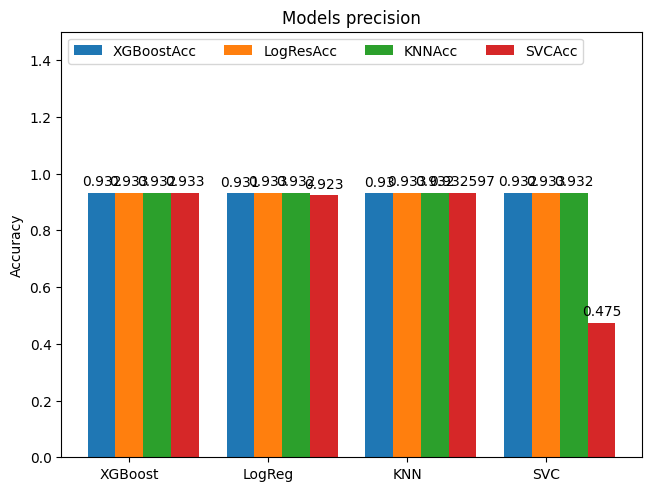

In [ ]:
models = ("XGBoost", "LogReg", "KNN", "SVC")
modelsAcc = {'XGBoostAcc':(round(gbcac1,3), round(gbcac2,3), round(gbcac3,3), round(gbcac4,3)),
              'LogResAcc':(round(lrac1,3), round(lrac2,3), round(lrac3,3), round(lrac4,3)),
              'KNNAcc':(round(knnac,3)),
              'SVCAcc':(round(svcac1,3), round(svcac2,3), round(svcac3,34), round(svcac4,3))}

x = np.arange(len(models))

width = 0.2
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in modelsAcc.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Accuracy')
ax.set_title('Models precision')
ax.set_xticks(x + width, models)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 1.5)

plt.show()


#Model selection

After reviewing the results there isn't a clearly superior model to use in this case, but the accuracy is no the only factor to decide which model can be better to use.

What we concluded was that the logistic regression would probably be the best to use, considering that the SVC takes too long, the XGBoost take too much computational processing and the KNN is better suited for small datasets.

Also, since the performance across models is so similar, it is suggested to expand the dataset variables to find ones that could improve the training.